**Importando Bibliotecas**

In [1]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import warnings;
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL);
from statsmodels.tools.eval_measures import rmse, rmspe;
from sklearn.metrics import mean_absolute_percentage_error as mape;
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf;
from itertools import product;
from pathlib import Path;

warnings.filterwarnings('ignore');
plt.rcParams['figure.figsize'] = [12,5]

**Importando os datasets**

In [2]:
arquivo_life = Path('../../datasets/Ch10/life_expectancy_birth.csv');
arquivo_milk = Path('../../datasets/Ch10/milk_production.csv');

life = pd.read_csv(arquivo_life, index_col='year', parse_dates=True, skipfooter=1);
milk = pd.read_csv(arquivo_milk, index_col='month', parse_dates=True);

In [3]:
life.head()

,value
year,
1960-01-01,69.123902
1961-01-01,69.760244
1962-01-01,69.149756
1963-01-01,69.248049
1964-01-01,70.311707


In [4]:
milk.head()

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


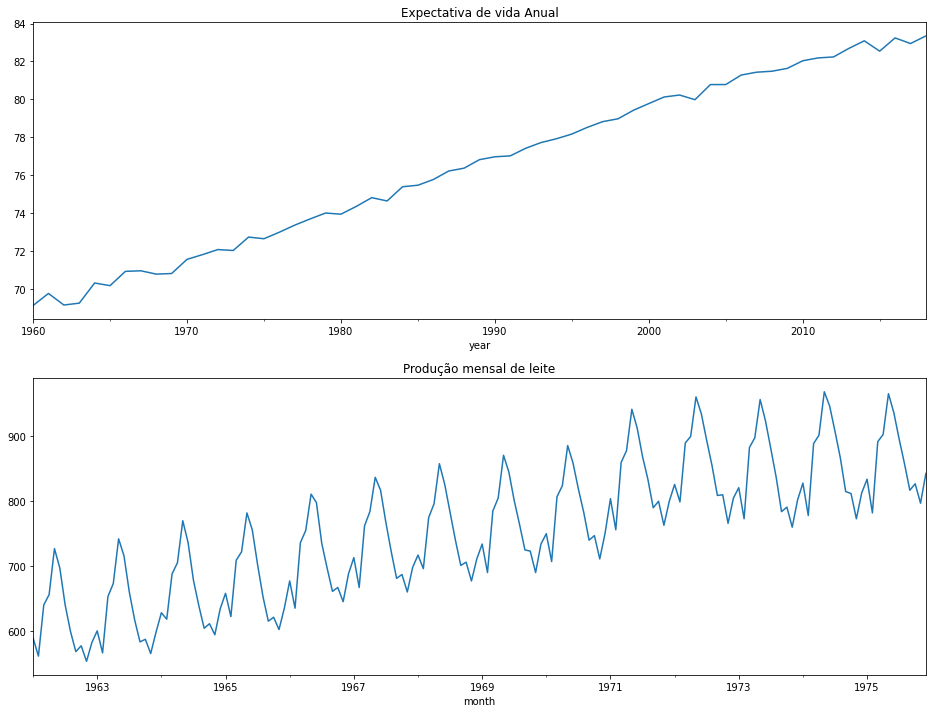

In [5]:
fig, ax = plt.subplots(2, 1, figsize = (16, 12));
life.plot(title='Expectativa de vida Anual', legend=False, ax=ax[0]);
milk.plot(title='Produção mensal de leite', legend=False, ax=ax[1]);